In [1]:
from time import time

import numpy as np
import scipy.stats as stats
import dask.array as da

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import sklearn

import dask_ml
from dask_ml.datasets import make_classification
from dask_ml.wrappers import Incremental
from dask_ml.model_selection import HyperbandCV
import dask_searchcv

from time import sleep
dask_ml.__file__

'/Users/ssievert/Developer/stsievert/dask-ml/dask_ml/__init__.py'

In [2]:
from distributed import Client, LocalCluster
procs, threads = 8, 8
num_workers = procs * threads
cluster = LocalCluster(n_workers=procs, threads_per_worker=threads)
client = Client(cluster)

In [3]:
# n, d = int(10e3), int(100)
# X, y = make_classification(n_features=d, n_samples=n,
#                            chunks=(n // 10, d))
# classes = da.unique(y)

# kwargs = dict(loss='hinge', penalty='elasticnet',
#               max_iter=1.0, warm_start=True)
# model = Incremental(SGDClassifier(), **kwargs)
# params = {'alpha': np.logspace(-4, 0, num=1000),
#           'l1_ratio': stats.uniform(0, 1),
#           'average': [True, False]}
# partial_fit_kwargs = {'classes': classes}

from dask_ml.utils import ConstantFunction
model = ConstantFunction()
params = {'value': stats.uniform(0, 1)}
sleep = 0.1
partial_fit_kwargs = {'sleep': sleep}

In [4]:
n, d = int(1000), int(200)
X, y = make_classification(n_features=d, n_samples=n,
                           chunks=(n//10, d))
alg = HyperbandCV(model, params, max_iter=81)

info = alg.info()

train_time = sleep * info['total_partial_fit_calls']
best_time = train_time / num_workers
print(f"Fastest possible time = {best_time}s")

Fastest possible time = 2.2171875s


In [5]:
start = time()
alg.fit(X, y, **partial_fit_kwargs)
actual_time = time() - start
print(f"Actual time = {actual_time}")

Actual time = 9.884281158447266


In [6]:
import pandas as pd
df = pd.DataFrame(alg.history_)
print(df.bracket.max())
print(df.bracket_iter.unique())
df.tail()
# df[df.mean_test_score > 0.95]

bracket=4
[0 1 2 3]


,bracket,bracket_iter,iterations,mean_copy_time,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,model_id,num_models,partial_fit_calls,score,std_fit_time,std_score_time,std_test_score,std_train_score
201,bracket=0,0,81,0.000186,8.450388,0.000088,0.497249,None,bracket=0-4,5,81,0.497249,0,0,0,None
202,bracket=0,0,81,0.000144,8.438286,0.000092,0.251782,None,bracket=0-3,5,81,0.251782,0,0,0,None
203,bracket=0,0,81,0.000155,8.439759,0.000086,0.971782,None,bracket=0-1,5,81,0.971782,0,0,0,None
204,bracket=1,1,81,0.000374,8.434756,0.000245,0.942910,None,bracket=1-4,2,81,0.942910,0,0,0,None
205,bracket=1,1,81,0.000436,8.441020,0.000253,0.703019,None,bracket=1-7,2,81,0.703019,0,0,0,None


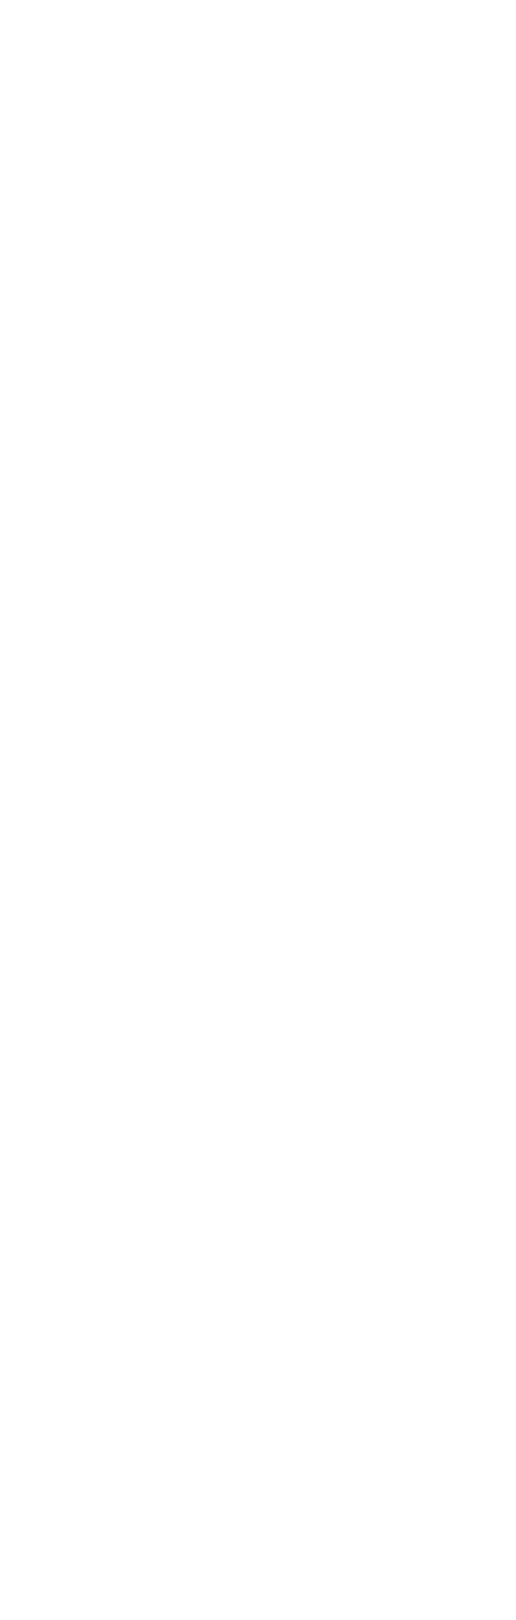

In [7]:
from altair import Chart
Chart(df).mark_circle().encode(
    x='bracket_iter', row='bracket', y='mean_test_score')